In [1]:
%matplotlib inline

from functools import reduce
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

#Pandas Options
pd.set_option('display.max_rows', 25)
pd.set_option('display.max_columns', 100)

#Set Seaborn Theme
sns.set_style('darkgrid')

In [2]:
#Function to plot confusion matrix.

import itertools
from sklearn.metrics import confusion_matrix
from pdpbox import pdp, get_dataset, info_plots

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    
    fig = plt.figure(1, figsize=(10, 6), dpi=600)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=16)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=14)
    plt.yticks(tick_marks, classes, fontsize=14)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black", fontsize=14)

    plt.ylabel('True label', fontsize=14)
    plt.xlabel('Predicted label', fontsize=14)
    plt.tight_layout()

# Data Collection For Counties

In [3]:
c_query = """
SELECT DISTINCT
  county
  , SAFE_DIVIDE(road_length, land_area) AS road_density
  , elev_mean
  , elev_range
  , winter_temp AS winter_temperature
  , SAFE_DIVIDE(population, land_area) AS population_density
  , male_rate
  , median_income
  , median_age
  , white_rate
  , avg_years_of_edu
  , unemployment_rate
  , SAFE_DIVIDE(housing_units, land_area) AS housing_density
  , house_owner_rate
  , newly_moved_household_rate
  , newly_built_housing_rate
  , law.laws_against
FROM broadband.tiger_acs_county_2016
LEFT JOIN broadband.laws_against_municipal_broadband law
  ON SUBSTR(tiger_acs_county_2016.county, 0, 2) = law.state_code
"""

county_data = pd.read_gbq(c_query, project_id='fccdsicapstone-218522', dialect='standard')

covered = pd.read_json('https://opendata.fcc.gov/resource/hwai-u4md.json?type=county&tech=acfow&speed=4&$limit=50000&$$app_token=gEs3nCbtYkVBxlJ8HyjVWP1OA&$select=id,sum(has_0),sum(has_1),sum(has_2),sum(has_3more)&$group=id',
                      dtype={'id': str})
covered['total'] = covered.sum_has_0 + covered.sum_has_1 + covered.sum_has_2 + covered.sum_has_3more
covered['pop_covered'] = (covered.total - covered.sum_has_0) / covered['total']
covered = covered[['id', 'pop_covered']]

all_data = pd.merge(county_data, covered, left_on='county', right_on='id', copy=False).drop('id', axis=1)
all_data.columns = ['county', 'Road Length Per Area', 'Elevation Mean', 'Elevation Range', 
                    'Average Winter Temperature', 'Population Density', 'Male %', 'Median Income', 'Median Age',
                    'White %', 'Average Years of Education', 'Unemployment Rate', 'Housing Density', 
                    '% Owner Occupied Units', '% Newly Moved Households', '% Newly Built Housing Units',
                    'Prohibition of Municipal Broadband', 'pop_covered']

In [4]:
all_data.shape

(3108, 18)

### Data Cleaning

Data completeness

In [5]:
all_data.count() / all_data.shape[0] * 100

county                                100.0
Road Length Per Area                  100.0
Elevation Mean                        100.0
Elevation Range                       100.0
Average Winter Temperature            100.0
Population Density                    100.0
Male %                                100.0
Median Income                         100.0
Median Age                            100.0
White %                               100.0
Average Years of Education            100.0
Unemployment Rate                     100.0
Housing Density                       100.0
% Owner Occupied Units                100.0
% Newly Moved Households              100.0
% Newly Built Housing Units           100.0
Prohibition of Municipal Broadband    100.0
pop_covered                           100.0
dtype: float64

In [6]:
data = all_data.dropna()

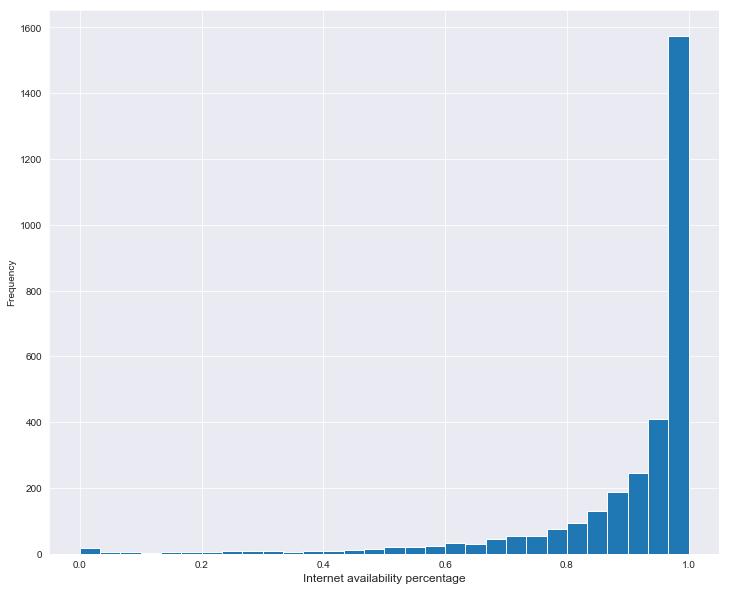

In [7]:
data['pop_covered'].plot.hist(bins=30, figsize=(12, 10))
plt.xlabel('Internet availability percentage', fontsize=12)
plt.show()

In [8]:
data = all_data.dropna()
data['pop_covered'].describe()

count    3108.000000
mean        0.902515
std         0.160427
min         0.000000
25%         0.883282
50%         0.967843
75%         0.995695
max         1.000000
Name: pop_covered, dtype: float64

# Correlation Analysis

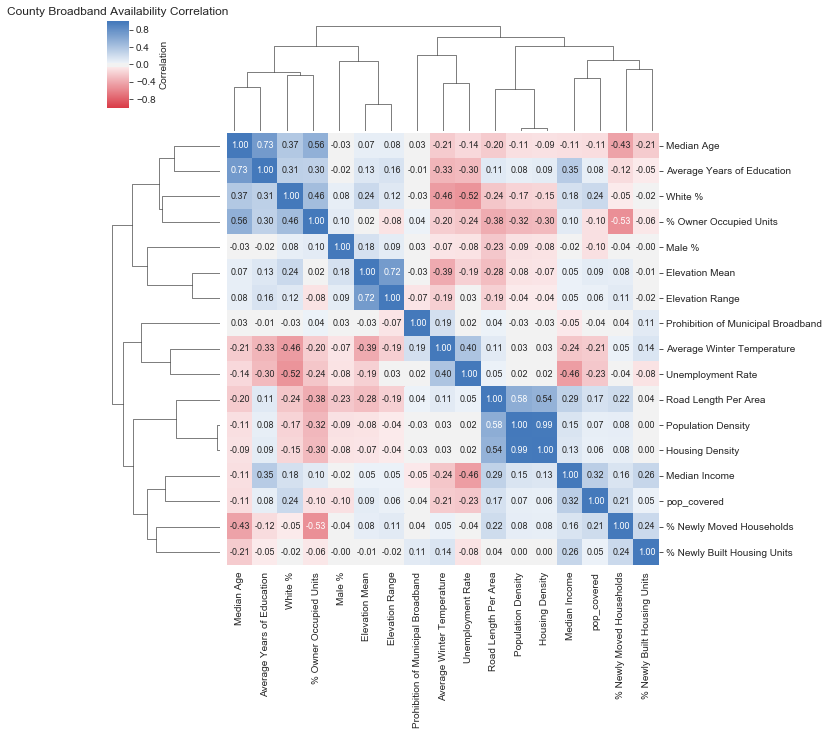

In [9]:
sns.clustermap(data.corr(), cmap=sns.diverging_palette(10, 250, as_cmap=True), square=True, vmin=-1.0,
               vmax=1.0, annot=True, fmt='.2f', annot_kws={'size': 9}, cbar_kws={'label': 'Correlation'})
plt.title('County Broadband Availability Correlation')
plt.show()

# Building a classification model for broadband availability.

In [10]:
pd.options.mode.chained_assignment = None
data['is_full_coverage'] = (data['pop_covered'] > 0.99)

In [11]:
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.model_selection import train_test_split

target_cols = ['is_full_coverage']
X = data.drop(columns=['county', 'pop_covered', *target_cols])
y = data[target_cols[0]]
w = compute_sample_weight('balanced', y)

X_train, X_test, y_train, y_test, w_train, w_test = train_test_split(X, y, w, test_size=0.2, stratify=y)

### Tuning tree-specific parameters
Tuning max_depth and min_samples_split first as they will have the highest impact on model outcome.

In [12]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV

param_fix = {'learning_rate': 0.05, 'n_estimators': 200, 'subsample': 0.8, 'max_features': 'sqrt', 
             'min_samples_leaf': 50}

clf = GradientBoostingClassifier(**param_fix)

param_grid = {'max_depth': np.linspace(20, 40, 3, dtype=int),
              'min_samples_split': np.linspace(40, 60, 3, dtype=int)}

grid_search = GridSearchCV(clf, param_grid, scoring='roc_auc', cv=5, n_jobs=-1, verbose=3)
grid_search.fit(X_train, y_train, **{'sample_weight': w_train})

print('Grid Searched Train Score:', grid_search.score(X_train, y_train))
print('Grid Searched Test Score:', grid_search.score(X_test, y_test))
print('Best Parameters:', grid_search.best_params_)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    9.6s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   15.7s finished


Grid Searched Train Score: 0.9905615904898545
Grid Searched Test Score: 0.7842545475814471
Best Parameters: {'max_depth': 40, 'min_samples_split': 40}


Confusion matrix, without normalization


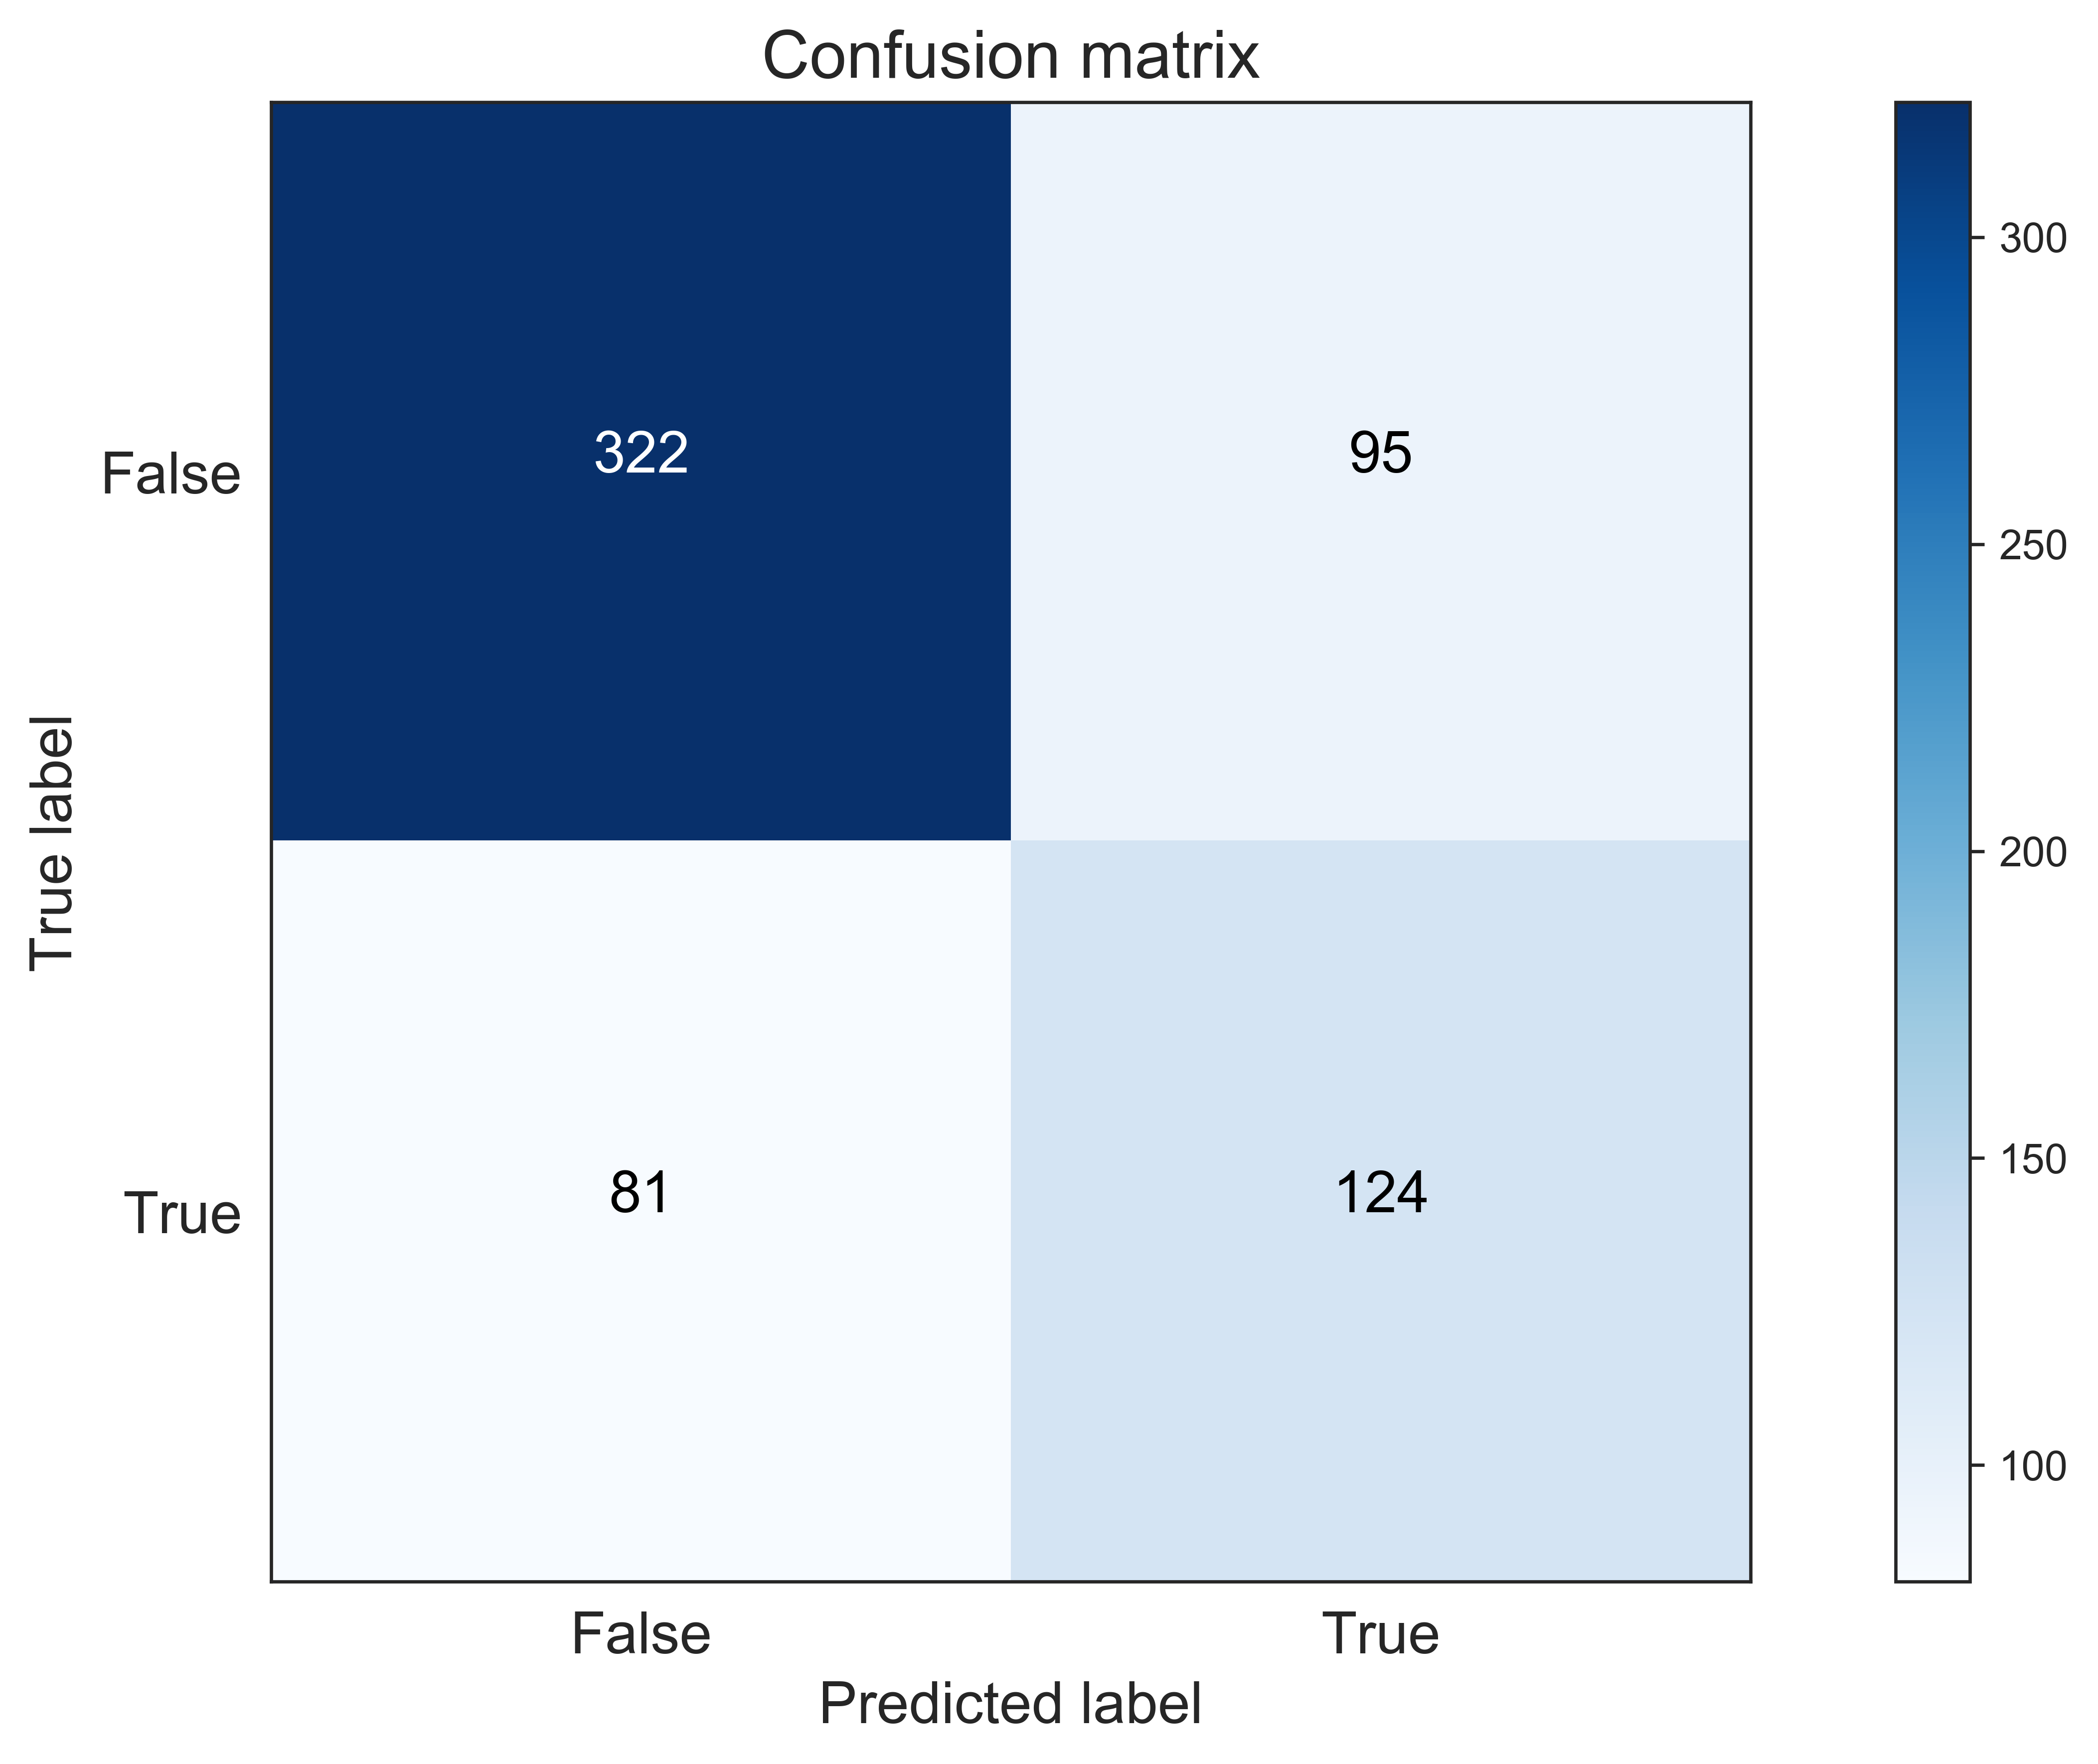

In [13]:
sns.set_style('white')

y_test_pred = grid_search.predict(X_test)
cm = confusion_matrix(y_test, y_test_pred)
plot_confusion_matrix(cm, classes=[False, True])

# Finding important features.

In [14]:
from eli5.sklearn import PermutationImportance

perm = PermutationImportance(grid_search.best_estimator_).fit(X_test, y_test)
coefficients = pd.DataFrame(list(zip(X.columns, perm.feature_importances_)), columns=['feature', 'importance'])
coefficients_sort = coefficients.sort_values('importance', ascending=False)

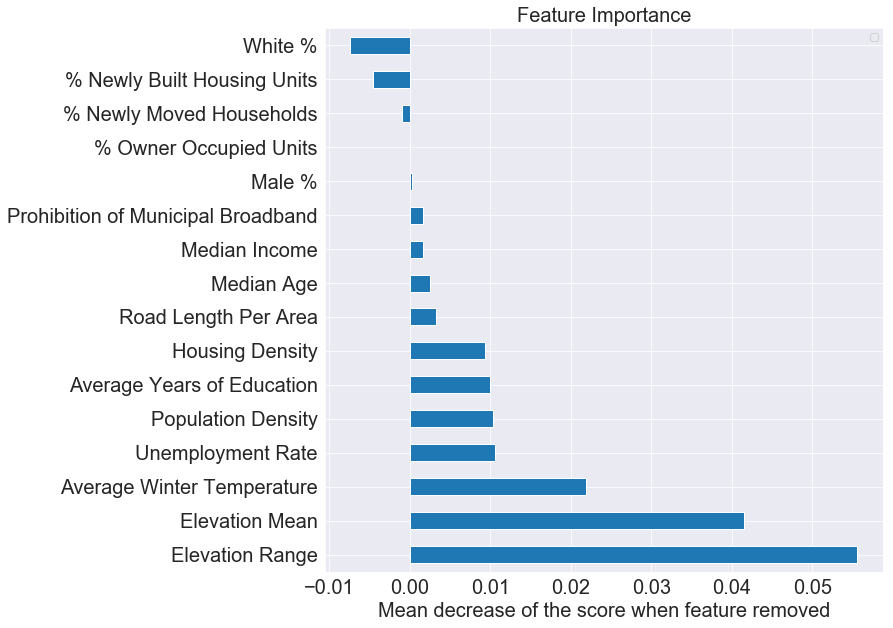

In [15]:
sns.set_style('darkgrid')

coefficients_sort.plot.barh(x='feature', figsize=(10, 10))
plt.xticks(fontsize=20)
plt.xlabel('Mean decrease of the score when feature removed', fontsize=20)
plt.yticks(fontsize=20)
plt.ylabel('')
plt.title('Feature Importance', fontsize=20)
plt.legend('')
plt.show()

# Finding partial dependance.

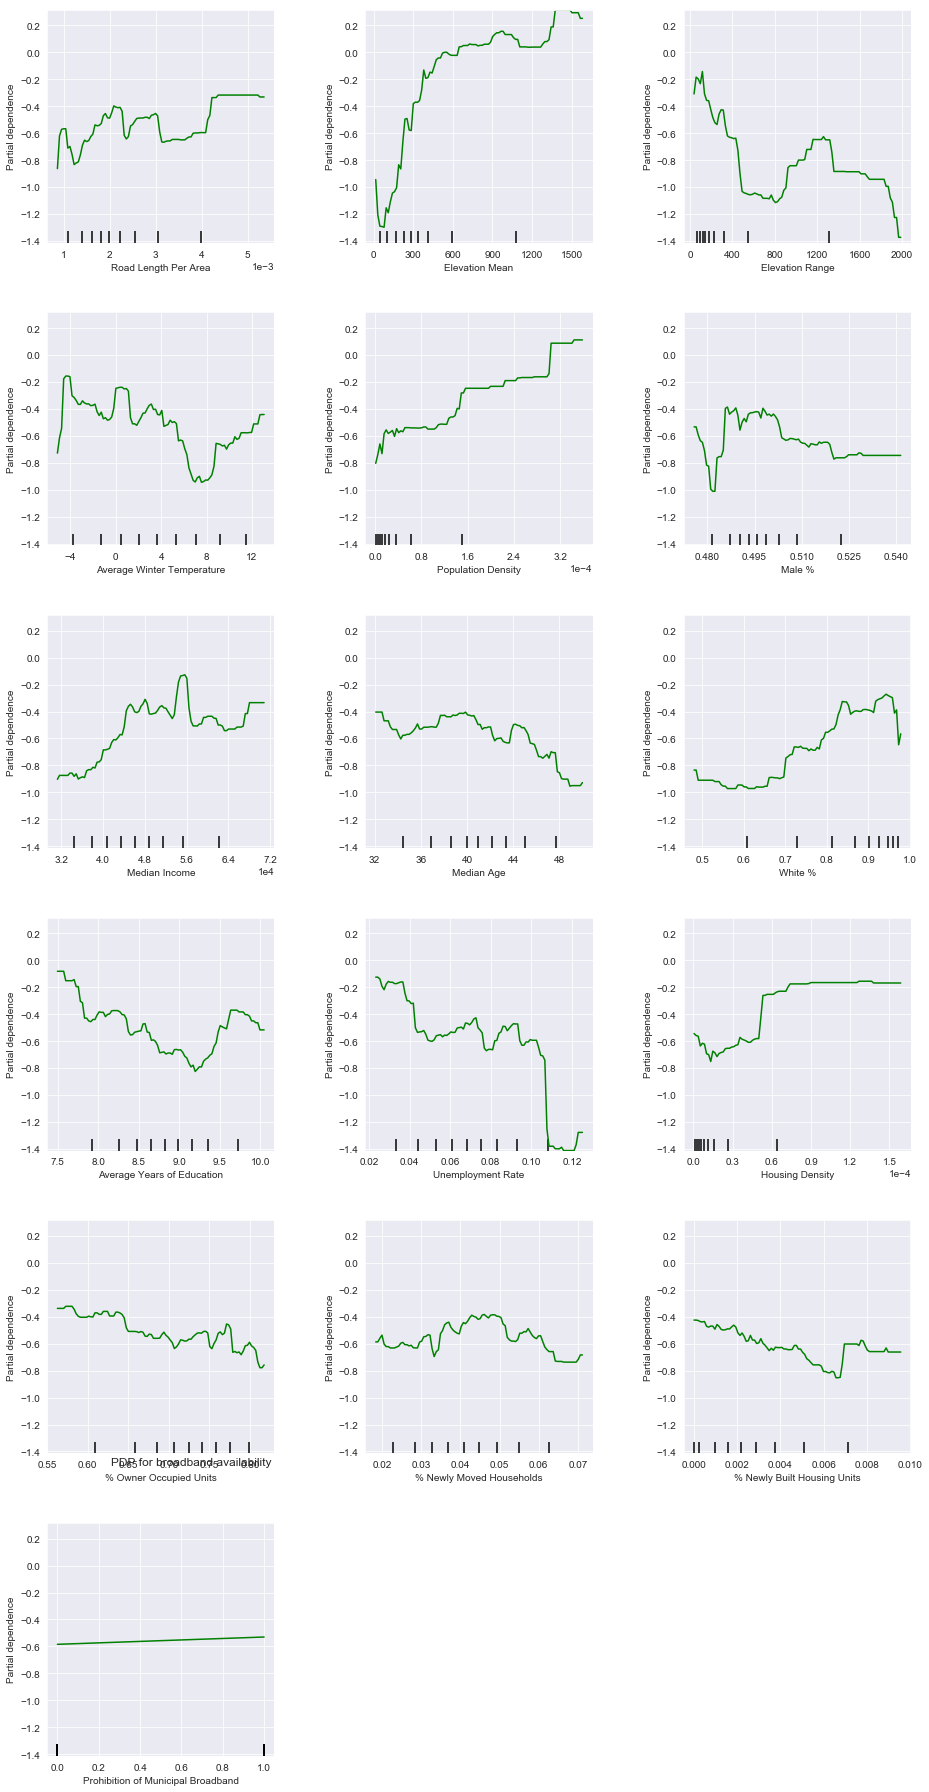

In [16]:
from sklearn.ensemble.partial_dependence import plot_partial_dependence

n_f = len(X.columns)
plot_partial_dependence(grid_search.best_estimator_, X_train, range(n_f), feature_names=X.columns, figsize=(5,5),
                        percentiles=(0.05, 0.95))
plt.subplots_adjust(top=5, right=2.5) 
plt.suptitle('PDP for broadband availability')
plt.show()

# Predicting the areas that is most likely to have full coverage

In [17]:
from sklearn.model_selection import cross_val_predict

y_pred = data['is_full_coverage']
proba = cross_val_predict(grid_search.best_estimator_, X, y_pred, method='predict_proba', cv=3)
data['proba'] = proba[:, 1]
cols = ['county', 'proba', 'pop_covered']
coverage = data[cols]

In [18]:
coverage.to_csv('broadband_prediction_county_result.csv', index=False)